### 1/17 追記
AutoEncoderとベイズを比較して、
`predicted image`と`p(P|Q)`の値がほぼ等しい結果が得られた.

それは一体なぜなのか考察してください.


また、この2つの間の違いを定量的に評価することは、発表の上で非常に重要な要素になりそうだと考えられます.
質よりも量で思いついた事、新しい知見などはお互い共有しよう. 何もアウトプットしないことだけは避けてほしいです.


橋爪さんからのアドバイスは以下の3つ.
- `predicted image with binalization`から`original image`に変換出来るか確認する
- `4x4MatrixGenerator.ipynb`のフィルター**A**の値を工夫する. 具体的には、より現実に近いケースを考える. 例として正規分布に従ったノイズ$\epsilon$を加えてみたり... (要考察)
- 実際の風景画や、大きなサイズにおいてこのアルゴリズムを適用してみる. ファミコンのドット絵とか面白そう? もしRGBに対応させるにはどうするか？　要考察

In [1]:
import numpy as np
import pandas as pd
import pydot
import matplotlib.pyplot as plt
import itertools as iter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, UpSampling2D

from PIL import Image

%matplotlib inline

### ベイズなし版

In [10]:
class AE():
    def __init__(self, optimizer='rmsprop', loss='mean_squared_error', input_data_path="../4x4matrix.csv"):
        self.p_matrix = np.load("4x4matrix.npz")["p_matrix"]
        self.q_matrix = np.load("4x4matrix.npz")["q_matrix"]
        self.optimizer = optimizer
        self.model = Sequential()
        #keras.layers.ReLU(max_value=1, negative_slope=0, threshold = 0)
        self.model.add( Dense(16, activation = tf.nn.relu, input_dim = 9) )
        self.model.add( Dense(16, activation = tf.nn.sigmoid ) )
        self.model.compile(optimizer = optimizer,
                           loss = loss,
                           metrics = ['accuracy'])
    def bayes(self, test_img):
        preds = self.model.predict(test_img).reshape(4,4)
        preds_binary = preds.copy()
        preds_binary[preds_binary < threshold] = 0
        preds_binary[preds_binary >= threshold] = 1
        print(preds, preds_binary)
        
        ncols = 5
        fig, axes = plt.subplots(nrows = 1, ncols = ncols, figsize = (16,16))
        bayes_image = np.empty(16)
        index_when_given_q = np.all(self.q_matrix == test_img.reshape(9,), axis = 1)
        p_given_q = self.p_matrix[index_when_given_q]
        print(p_given_q)
        for col in range(16):
            is_one_counter = 0
            target_list = [p_given_q[row][col] for row in range(p_given_q.shape[0])]
            total_length = len(target_list)
            print(total_length)
            for j in range(total_length):
                if target_list[j] == 1:
                    is_one_counter += 1
                prob = is_one_counter / total_length
                bayes_image[col] = prob
        
        axes[0].imshow(test_img.reshape(3,3), cmap = plt.cm.binary)
        axes[0].set_title("original image")
        axes[1].imshow(preds, cmap = plt.cm.binary)
        axes[1].set_title("predicted image")
        axes[2].imshow(preds_binary, cmap = plt.cm.binary)
        axes[2].set_title("predicted image with binalization")
        axes[3].imshow(bayes_image.reshape(4,4), cmap = plt.cm.binary)
        axes[3].set_title("p(P|Q) image based on bayes")
        bayes_image[ bayes_image < thresold ] = 0
        bayes_image[ bayes_image >= thresold ] = 1
        axes[4].imshow(bayes_image.reshape(4,4), cmap = plt.cm.binary)
        axes[4].set_title("p(P|Q) image based on bayes with binalization")
        
    def fit(self, epochs='4', batch_size='256'):
        self.model.fit(self.q_matrix, self.p_matrix,
                      epochs = epochs,
                      batch_size = batch_size,
                      validation_data = (self.q_matrix, self.p_matrix))
    
    def predict(self, test_img, threshold):
        preds = self.model.predict(test_img).reshape(4,4)
        preds_binary = preds.copy()
        preds_binary[preds_binary < threshold] = 0
        preds_binary[preds_binary >= threshold] = 1
        ncols = 3
        fig, axes = plt.subplots(nrows = 1, ncols = ncols, figsize = (14,14))
        axes[0].imshow(test_img.reshape(3,3), cmap = plt.cm.binary)
        axes[0].set_title("original image")
        axes[1].imshow(preds, cmap = plt.cm.binary)
        axes[1].set_title("predicted image")
        axes[2].imshow(preds_binary, cmap = plt.cm.binary)
        axes[2].set_title("predicted image with binalization")
    
    def predict_RGB(self, test_img, threshold):
        preds = np.empty((4,4,3), dtype='float32')
        preds_binary = np.empty((4,4,3), dtype='float32')
        for dim in range(test_img.shape[2]):
            preds[ : , : , dim] = self.model.predict(test_img[ : , : , dim].reshape(1,9)).reshape(4,4)
            preds_binary[ : , : , dim] = preds[ : , : , dim].copy()
        preds_binary[preds_binary < threshold] = 0
        preds_binary[preds_binary >= threshold] = 1
        ncols = 3
        fig, axes = plt.subplots(nrows = 1, ncols = ncols, figsize = (14,14))
        axes[0].imshow(test_img, cmap = plt.cm.binary)
        axes[0].set_title("original image")
        axes[1].imshow(preds, cmap = plt.cm.binary)
        axes[1].set_title("predicted image")
        axes[2].imshow(preds_binary, cmap = plt.cm.binary)
        axes[2].set_title("predicted image with binalization")
        
    def SR(self, input_img, thresold):
        # Preprocessing area
        x, y, z = input_img.shape # dimention x and y
        pad_list = [] # padding count x = 0, y = 1
        for i in [x, y]:
            if i % 3 == 0:
                pad_list.append(0)
            elif i % 3 == 1:
                pad_list.append(2)
            else:
                pad_list.append(1)
        
        temp = np.zeros((x + pad_list[0], y + pad_list[1], 3), dtype='float32') # new temporary array replaced with input_img
        temp[ 0 : x, 0 : y , 0 : z] = input_img
        input_img = temp
        m,n = int(input_img.shape[0] / 3), int(input_img.shape[1] / 3)
        output_img = np.empty((4 * m , 4 * n, 3), dtype='float32')
        print(pad_list[0], pad_list[1])
        
        # SR area
        for dim in [0,1,2]:
            for i, j in iter.product(range(n), range(m)):
                partial_img = input_img.copy()[ 3 * j : 3 * ( j + 1 ), 3 * i : 3 * ( i + 1), dim] 
                if np.all(partial_img < 0.1):
                    partial_img = np.zeros(16)
                else:
                    partial_img = self.model.predict( partial_img.reshape(1,9) )
                output_img[4 * j : 4 * (j + 1), 4 * i : 4 * ( i + 1), dim] = partial_img.reshape(4,4)
        
        max_val = output_img.max()
        output_img /= max_val
        output_img_binalized = output_img.copy()
        output_img_binalized[output_img_binalized >= thresold] = 1
        output_img_binalized[output_img_binalized < thresold] = 0

        fig, axes = plt.subplots(1,3, figsize = (16,16))
        axes[0].imshow(input_img, cmap = plt.cm.binary)
        axes[0].set_title("input image")
        axes[1].imshow(output_img, cmap = plt.cm.binary)
        axes[1].set_title("output image")
        axes[2].imshow(output_img_binalized, cmap = plt.cm.binary)
        axes[2].set_title("output image with biinalization")
        
        return output_img
    
    def SR2(self, file_path, mean = 0 , sd = 0.2):
        # Resizing area
        input_img = Image.open(file_path)
        img_width, img_height = input_img.size
        
        ratio = 3 / 4
        resized_width =  int(input_img.size[0] * ratio)
        resized_height = int(input_img.size[1] * ratio)
        resized_img = input_img.resize((resized_width, resized_height))
        resized_img = np.array(resized_img, "f") / 255
        resized_img = resized_img + np.random.normal(mean, sd, (resized_height, resized_width, 3))
        input_img = np.array(input_img, 'f') / 255
        
        # Preprocessing area
        x, y, z = resized_img.shape # dimention x and y
        pad_list = [] # padding count x = 0, y = 1
        for i in [x, y]:
            if i % 3 == 0:
                pad_list.append(0)
            elif i % 3 == 1:
                pad_list.append(2)
            else:
                pad_list.append(1)
        
        temp = np.zeros((x + pad_list[0], y + pad_list[1], 3), dtype='float32') # new temporary array replaced with input_img
        temp[ 0 : x, 0 : y , 0 : z] = resized_img
        resized_img = temp
        m,n = int(resized_img.shape[0] / 3), int(resized_img.shape[1] / 3)
        output_img = np.empty((4 * m , 4 * n, 3), dtype='float32')
        print(pad_list[0], pad_list[1])
        
        # SR area
        for dim in [0,1,2]:
            for i, j in iter.product(range(n), range(m)):
                partial_img = resized_img.copy()[ 3 * j : 3 * ( j + 1 ), 3 * i : 3 * ( i + 1), dim] 
                if np.all(partial_img < 0.1):
                    partial_img = np.zeros(16)
                else:
                    partial_img = self.model.predict( partial_img.reshape(1,9) )
                output_img[4 * j : 4 * (j + 1), 4 * i : 4 * ( i + 1), dim] = partial_img.reshape(4,4)
        
        max_val = output_img.max()
        output_img /= max_val

        fig, axes = plt.subplots(1,3, figsize = (15,15))
        axes[0].imshow(input_img, cmap = plt.cm.binary)
        axes[0].set_title("input image")
        axes[1].imshow(resized_img, cmap = plt.cm.binary)
        axes[1].set_title("resized image")
        axes[2].imshow(output_img, cmap = plt.cm.binary)
        axes[2].set_title("output image")
        return output_img

In [11]:
autoencoder = AE(optimizer = tf.train.AdamOptimizer(learning_rate = 1e-3)  , loss = tf.keras.losses.mean_squared_error  )
#autoencoder = AE(optimizer = tf.train.AdamOptimizer(learning_rate=5e-4) , loss = tf.keras.losses.binary_crossentropy)

## モデル

In [12]:
autoencoder.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 16)                160       
_________________________________________________________________
dense_9 (Dense)              (None, 16)                272       
Total params: 432
Trainable params: 432
Non-trainable params: 0
_________________________________________________________________


## 学習

In [15]:
autoencoder.fit(epochs = 100, batch_size=512)

Train on 65536 samples, validate on 65536 samples
Epoch 1/100
65536/65536 [==============================] - 0s 7us/step - loss: 0.0940 - acc: 0.1041 - val_loss: 0.0940 - val_acc: 0.0840
Epoch 2/100
65536/65536 [==============================] - 0s 7us/step - loss: 0.0940 - acc: 0.0989 - val_loss: 0.0941 - val_acc: 0.0995
Epoch 3/100
65536/65536 [==============================] - 0s 6us/step - loss: 0.0940 - acc: 0.0973 - val_loss: 0.0941 - val_acc: 0.1161
Epoch 4/100
65536/65536 [==============================] - 0s 7us/step - loss: 0.0940 - acc: 0.1013 - val_loss: 0.0940 - val_acc: 0.1078
Epoch 5/100
65536/65536 [==============================] - 0s 6us/step - loss: 0.0940 - acc: 0.1015 - val_loss: 0.0940 - val_acc: 0.1216
Epoch 6/100
65536/65536 [==============================] - 0s 7us/step - loss: 0.0940 - acc: 0.1035 - val_loss: 0.0940 - val_acc: 0.1394
Epoch 7/100
65536/65536 [==============================] - 0s 6us/step - loss: 0.0941 - acc: 0.1064 - val_loss: 0.0940 - val_acc

65536/65536 [==============================] - 0s 7us/step - loss: 0.0941 - acc: 0.1057 - val_loss: 0.0940 - val_acc: 0.1003
Epoch 61/100
65536/65536 [==============================] - 0s 7us/step - loss: 0.0940 - acc: 0.1083 - val_loss: 0.0940 - val_acc: 0.0789
Epoch 62/100
65536/65536 [==============================] - 0s 7us/step - loss: 0.0940 - acc: 0.1043 - val_loss: 0.0941 - val_acc: 0.0952
Epoch 63/100
65536/65536 [==============================] - 0s 7us/step - loss: 0.0940 - acc: 0.1050 - val_loss: 0.0940 - val_acc: 0.0804
Epoch 64/100
65536/65536 [==============================] - 0s 7us/step - loss: 0.0940 - acc: 0.1031 - val_loss: 0.0940 - val_acc: 0.1026
Epoch 65/100
65536/65536 [==============================] - 0s 7us/step - loss: 0.0940 - acc: 0.1097 - val_loss: 0.0940 - val_acc: 0.1108
Epoch 66/100
65536/65536 [==============================] - 0s 7us/step - loss: 0.0940 - acc: 0.1033 - val_loss: 0.0940 - val_acc: 0.0821
Epoch 67/100
65536/65536 [=====================

## 予測
### モノクロ版

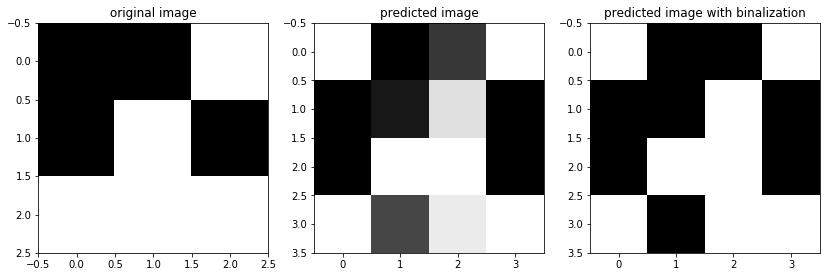

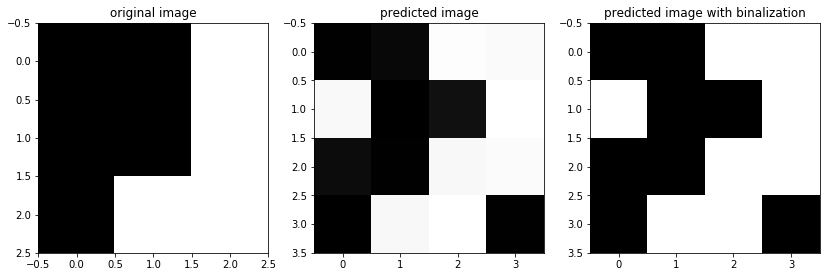

In [16]:
for i in range(2):
    test_img = np.random.randint(0, 2, size=(1,9))
    threshold = 0.5
    autoencoder.predict(test_img, threshold)

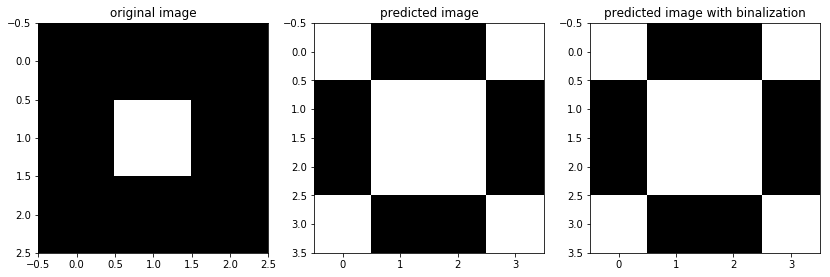

In [17]:
test_img = np.array([[1,1,1,1,0,1,1,1,1]])
threshold = 0.5
autoencoder.predict(test_img, threshold)

## 画像作る用

In [18]:
def set_dataset(index):
    p_matrix_list = [
        np.array([1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,0]).reshape(4,4),
        np.array([1, 0.5, 0, 0.5, 1, 0.5, 0, 0.5, 1, 0.5, 0, 0.5, 1, 0.5, 0, 0.5]).reshape(4,4),
        0
    ]
    
    q_matrix_list = [
        np.array([[1,1,1,1,0.75,0.5,1,0.5,0]]),
        np.array([[0.75, 0.25, 0.25, 0.75, 0.25, 0.25, 0.75, 0.25, 0.25]]),
        np.array([[1, 1, 1, 1, 0, 1, 1, 1, 1]])
    ]
    
    global file_path
    file_path = [
        "p_matrix_" + str(index) + ".pdf",
        "q_matrix_" + str(index) + ".pdf",
        "output_" + str(index) + ".pdf"
    ]
    
    global output 
    output = autoencoder.model.predict(q_matrix_list[index]).reshape(4,4)
    
    global p_matrix
    p_matrix = p_matrix_list[index]
    
    global q_matrix
    q_matrix = q_matrix_list[index].reshape(3,3)

In [47]:
set_dataset(1)
print(output)
print("MSE : " + str(np.sum((p_matrix - output) ** 2)))

[[0.988223   0.511789   0.01264445 0.505443  ]
 [0.9876538  0.49935985 0.01283929 0.50383615]
 [0.9889585  0.49283004 0.01137911 0.4976425 ]
 [0.9885548  0.48448843 0.01377994 0.4708836 ]]
MSE : 0.002517207362326617


### P行列

TypeError: Invalid dimensions for image data

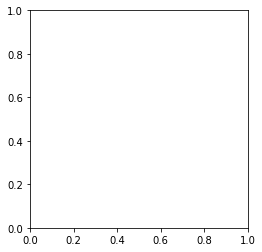

In [43]:
plt.colorbar(plt.imshow(p_matrix, cmap = plt.cm.binary))
plt.savefig(file_path[0], transparent = True )
plt.figure(figsize = (6,6))

### Q行列

<Figure size 432x432 with 0 Axes>

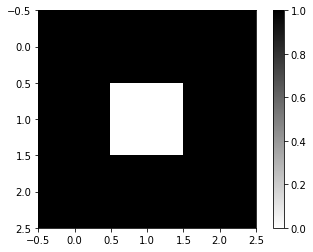

<Figure size 432x432 with 0 Axes>

In [44]:
plt.colorbar(plt.imshow(q_matrix, cmap = plt.cm.binary))
plt.savefig(file_path[1], transparent = True)
plt.figure(figsize = (6,6))

### 出力(output)

<Figure size 432x432 with 0 Axes>

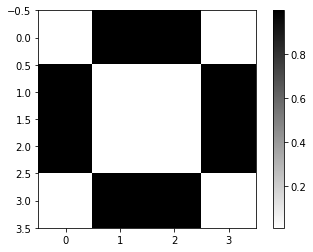

<Figure size 432x432 with 0 Axes>

In [45]:
plt.colorbar(plt.imshow(output, cmap = plt.cm.binary))
plt.savefig(file_path[2], transparent = True)
plt.figure(figsize = (6,6))

### RGB版

In [ ]:
for i in range(3):
    test_img = np.random.rand(3,3,3)
    threshold = 0.5
    autoencoder.predict_RGB(test_img, threshold)

## より大きな画像で超解像を行う

### 仕様
- `input_img` 
    - (3 x n, 3 x m) dimention
    - from 0 to 1 
    
- `output_img`
    - (4 x n, 4 x m) dimention
    - 0 or 1 binalized
    
- `thresold`

Text(0.5, 1.0, 'output image with biinalization')

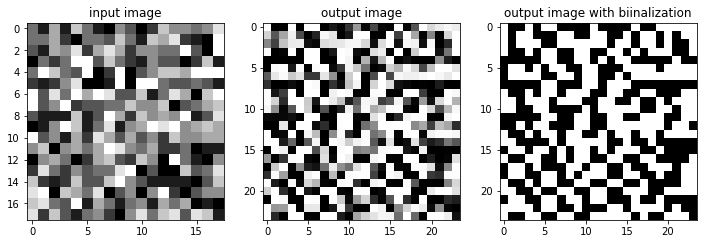

In [48]:
# n = 4
# m = 4
thresold = 0.5
input_img = np.random.randint(0, 10, (18,18), dtype='int8') / 10
x, y = input_img.shape
n, m = int( x / 3 ), int( y / 3 )
output_img = np.empty((4 * n , 4 * m), dtype='float64')

for i, j in iter.product(range(n), range(m)):
    partial_img = input_img.copy()[ 3 * j : 3 * (j + 1), 3 * i : 3 * ( i + 1)] 
    partial_img = autoencoder.model.predict(partial_img.reshape(1,9))
    output_img[4 * j : 4 * (j + 1), 4 * i : 4 * ( i + 1)] = partial_img.reshape(4,4)

output_img_binalized = output_img.copy()
output_img_binalized[output_img_binalized >= thresold] = 1
output_img_binalized[output_img_binalized < thresold] = 0

fig, axes = plt.subplots(1,3, figsize = (12,12))
axes[0].imshow(input_img, cmap = plt.cm.binary)
axes[0].set_title("input image")
axes[1].imshow(output_img, cmap = plt.cm.binary)
axes[1].set_title("output image")
axes[2].imshow(output_img_binalized, cmap = plt.cm.binary)
axes[2].set_title("output image with biinalization")

## メソッド版
- `img1.jpeg` : 理科大マーク
- `img2.jpg` : 激重
- `img3.jpg` : 葛飾
- `img4.jpg` : ロックマン

2 2


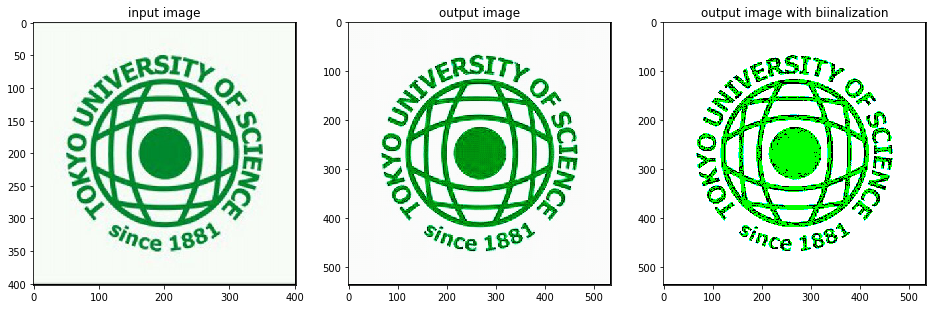

In [50]:
input_img = np.array(Image.open("img/img1.jpg"), "f") / 255
output_img = autoencoder.SR(input_img, 0.5)
img = Image.fromarray(np.uint8(255 * output_img))
img.save('img/img1_2.jpg', quality=95)

## 画像劣化と超解像

左から順に
- `input_image`
- `Pillowによりサイズダウンされた画像` 
- `サイズダウンされた画像の超解像画像`

In [ ]:
file_path = "img/img4.jpg"
input_img = Image.open(file_path)

img_width, img_height = input_img.size
ratio = 3 / 4
resized_width =  int(input_img.size[0] * ratio)
resized_height = int(input_img.size[1] * ratio)

resized_img = input_img.resize((resized_width, resized_height))
resized_img = np.array(resized_img, "f") / 255


output_img = autoencoder.SR(resized_img, 0.5)


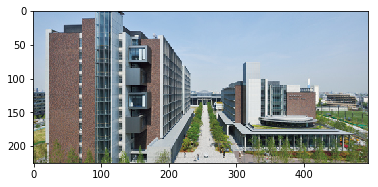

In [51]:
input_img = Image.open("img/img3.jpg")

img_width, img_height = input_img.size
ratio = 3 / 4
resized_width =  int(input_img.size[0] * ratio)
resized_height = int(input_img.size[1] * ratio)

resized_img = input_img.resize((resized_width, resized_height))
resized_img = np.array(resized_img, "f") / 255

plt.imshow(resized_img)
plt.savefig("resized_img.pdf")

0 0


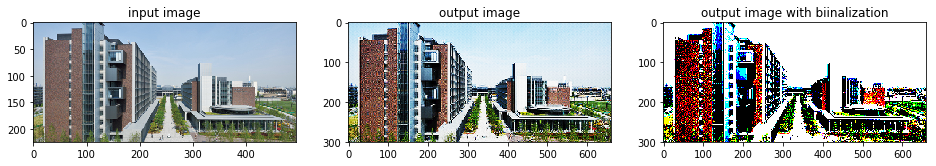

In [52]:
output_img = autoencoder.SR(resized_img, 0.5)
img = Image.fromarray(np.uint8(255 * output_img))
img.save('img/output_img.jpg', quality=95)

## 平均プーリング

In [74]:
def pooling(input_array):
    input_array.reshape(16)
    kernel = np.array([
            [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1]
        ], dtype="float16")
    return np.dot(kernel, input_array) / 4
    

img = plt.imread("img/img3.jpg") / 255
x, y, z = img.shape # dimention x and y
pad_list = [] # padding count x = 0, y = 1
for i in [x, y]:
    if i % 4 == 0:
        pad_list.append(0)
    elif i % 4 == 1:
        pad_list.append(3)
    elif i % 4 == 2:
        pat_list.appemd(2)
    else:
        pad_list.append(1)
        
temp = np.zeros((x + pad_list[0], y + pad_list[1], 3), dtype='float32') # new temporary array replaced with input_img
temp[ 0 : x, 0 : y , 0 : z] = img
img = temp
m,n = int(img.shape[0] / 4), int(img.shape[1] / 4)
pooled_img = np.empty((3 * m , 3 * n, 3), dtype='float32')

for dim in [0,1,2]:
    for i, j in iter.product(range(n), range(m)):
        partial_img = img.copy()[ 4 * j : 4 * ( j + 1 ), 4 * i : 4 * ( i + 1), dim].reshape(16) 
        partial_img = pooling(partial_img)
        pooled_img[3 * j : 3 * (j + 1), 3 * i : 3 * ( i + 1), dim] = partial_img.reshape(3,3)

(225, 495, 3)


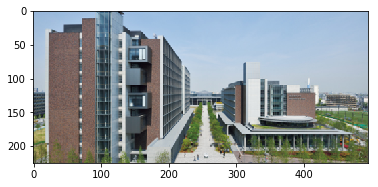

In [79]:
print(pooled_img.shape)
plt.imshow(pooled_img)
plt.savefig("pooled.jpg", transparent=True)

0 0


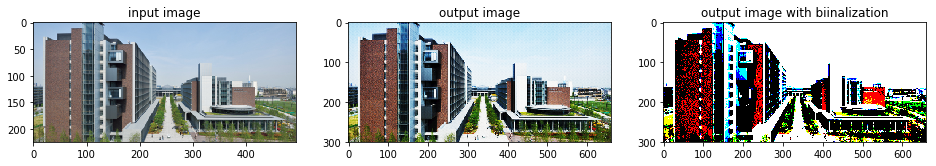

In [76]:
output_img = autoencoder.SR(pooled_img, 0.5)
img = Image.fromarray(np.uint8(255 * output_img))
img.save('img/from_pooled.jpg', quality=95)

In [94]:
print((plt.imread("img/from_pooled.jpg") - plt.imread("img/img3.jpg")) / 255)

mse = np.sum(( plt.imread("img/from_pooled.jpg")/255 - plt.imread("img/img3.jpg")/255 ) ** 2) / (300 * 660 * 3)
print("MSE : " + str(mse))

[[[0.10588235 0.15686275 0.10980392]
  [0.10196078 0.15294118 0.10588235]
  [0.10980392 0.16078431 0.11372549]
  ...
  [0.13333333 0.15686275 0.10980392]
  [0.14509804 0.16862745 0.12156863]
  [0.12941176 0.15294118 0.12156863]]

 [[0.10196078 0.15294118 0.10588235]
  [0.10196078 0.15294118 0.10588235]
  [0.11372549 0.16470588 0.11764706]
  ...
  [0.10588235 0.1372549  0.08627451]
  [0.1254902  0.15686275 0.10588235]
  [0.1254902  0.15686275 0.11372549]]

 [[0.11764706 0.16862745 0.12156863]
  [0.09019608 0.14117647 0.09411765]
  [0.08235294 0.13333333 0.08627451]
  ...
  [0.10980392 0.14901961 0.09019608]
  [0.12941176 0.16862745 0.11764706]
  [0.10980392 0.14509804 0.10196078]]

 ...

 [[0.98039216 0.97647059 0.93333333]
  [0.10588235 0.08235294 0.99215686]
  [0.03137255 0.02745098 0.00784314]
  ...
  [0.8        0.81960784 0.82745098]
  [0.9254902  0.91764706 0.92941176]
  [0.85490196 0.84705882 0.89803922]]

 [[0.84313725 0.84705882 0.81568627]
  [0.84705882 0.91372549 0.79607843]


In [ ]:
file_path = "img/img3.jpg"
autoencoder.SR2(file_path, mean = 0, sd = 0)

## ベイズあり

In [ ]:
test_img = np.array([[1,1,1,0.5,0.5,0.5,0.5,0.5,0.5]])
test_img = np.array([[0.5, 0.5,0.5,0.5,0.5,0.5,0.75,1,1]])
autoencoder.bayes(test_img)

### ゴミ

In [ ]:
output_img = autoencoder.SR(output_img, 0.5)
img = Image.fromarray(np.uint8(255 * output_img))
img.save('img/img3_a(0_1)_twice.jpg', quality=95)

## ベイズルールによる結果(Duplicated)

In [ ]:
index_when_given_q = np.all(autoencoder.q_matrix == test_img, axis = 1)
p_given_q = autoencoder.p_matrix[index_when_given_q]

In [ ]:
n = 16
for i in range(n):
    ax = plt.subplot(4, 4, i+1)
    plt.hist([p_given_q[j][i] for j in range(p_given_q.shape[0])], bins = [0,1,2])

In [ ]:
n = 16
bayes_image = np.empty(n)
for i in range(n):
    is_one_counter = 0
    target_list = [p_given_q[j][i] for j in range(p_given_q.shape[0])]
    total_length = len(target_list)
    
    for j in range(total_length):
        if target_list[j] == 1:
            is_one_counter += 1
    prob = is_one_counter / total_length
    bayes_image[i] = prob

In [ ]:
bayes_image

In [ ]:
plt.imshow(bayes_image.reshape(4,4), cmap = plt.cm.binary)

In [ ]:
test = np.random.randint(0,2,(6,4))
x, y = test.shape
xy = 0 #count x = 0, y = 1
pad_list = []
for i in [x, y]:
    if i % 3 == 0:
        pad_list.append(0)
    elif i % 3 == 1:
        pad_list.append(2)
    else:
        pad_list.append(1)
    xy += 1

test_ = np.zeros((x + pad_list[0], y + pad_list[1]))
print(test_.shape)

In [ ]:
np.arange(6).reshape(1,2,3)

In [ ]:
np.array(Image.open("img/img4.jpg"), "f").shape

In [ ]:
class AE():
    def __init__(self, optimizer='rmsprop', loss='mean_squared_error', input_data_path="../4x4matrix.csv"):
        self.p_matrix = np.load("4x4matrix.npz")["p_matrix"]
        self.q_matrix = np.load("4x4matrix.npz")["q_matrix"]
        self.optimizer = optimizer
        self.model = Sequential()
        self.model.add( Dense(16, activation = 'relu', input_dim = 9) )
        #self.model.add( Dense(16, activation = 'relu') )
        self.model.add( Dense(16, activation = 'relu') )
        self.model.add( Dense(16, activation = 'relu') )
        #self.model.add( Dense(16, activation = keras.layers.ReLU(max_value=1, negative_slope=0, threshold = 0)) )
        #self.model.add( Dense(16, activation = keras.layers.ReLU(max_value=1, negative_slope=0, threshold = 0)) )
        self.model.compile(optimizer = optimizer,
                           loss = loss,
                           metrics = ['accuracy'])
        
    def fit(self, epochs='4', batch_size='256'):
        self.model.fit(self.q_matrix, self.p_matrix,
                      epochs = epochs,
                      batch_size = batch_size,
                      validation_data = (self.q_matrix, self.p_matrix))
    
    def predict(self, test_img, threshold):
        preds = self.model.predict(test_img).reshape(4,4)
        preds_binary = preds.copy()
        preds_binary[preds_binary < threshold] = 0
        preds_binary[preds_binary >= threshold] = 1
        print(preds, preds_binary)
        
        if test_img.dtype == 'int64':
            ncols = 5
            fig, axes = plt.subplots(nrows = 1, ncols = ncols, figsize = (14,14))
            bayes_image = np.empty(16)
            index_when_given_q = np.all(self.q_matrix == test_img.reshape(9,), axis = 1)
            p_given_q = self.p_matrix[index_when_given_q]
            print(p_given_q)
            for col in range(16):
                is_one_counter = 0
                target_list = [p_given_q[row][col] for row in range(p_given_q.shape[0])]
                total_length = len(target_list)
    
                for j in range(total_length):
                    if target_list[j] == 1:
                        is_one_counter += 1
                prob = is_one_counter / total_length
                bayes_image[i] = prob
            axes[3].imshow(bayes_image.reshape(4,4), cmap = plt.cm.binary)
            axes[3].set_title("p(P|Q) image based on bayes")
            bayes_image[ bayes_image < thresold ] = 0
            bayes_image[ bayes_image >= thresold ] = 1
            axes[4].imshow(bayes_image.reshape(4,4), cmap = plt.cm.binary)
            axes[4].set_title("p(P|Q) image based on bayes with binalization")
            
        elif test_img.dtype == 'float64':
            ncols = 3
            fig, axes = plt.subplots(nrows = 1, ncols = ncols, figsize = (14,14))
        

        axes[0].imshow(test_img.reshape(3,3), cmap = plt.cm.binary)
        axes[0].set_title("original image")
        axes[1].imshow(preds, cmap = plt.cm.binary)
        axes[1].set_title("predicted image")
        axes[2].imshow(preds_binary, cmap = plt.cm.binary)
        axes[2].set_title("predicted image with binalization")
        
    def SR(self, input_img, thresold):
        # Preprocessing area
        x, y, z = input_img.shape # dimention x and y
        pad_list = [] # padding count x = 0, y = 1
        for i in [x, y]:
            if i % 3 == 0:
                pad_list.append(0)
            elif i % 3 == 1:
                pad_list.append(2)
            else:
                pad_list.append(1)
        
        temp = np.zeros((x + pad_list[0], y + pad_list[1], 3), dtype='float32') # new temporary array replaced with input_img
        temp[ 0 : x, 0 : y , 0 : z] = input_img
        input_img = temp
        m,n = int(input_img.shape[0] / 3), int(input_img.shape[1] / 3)
        output_img = np.empty((4 * m , 4 * n, 3), dtype='float32')
        print(pad_list[0], pad_list[1])
        
        # SR area
        for dim in [0,1,2]:
            for i, j in iter.product(range(n), range(m)):
                partial_img = input_img.copy()[ 3 * j : 3 * ( j + 1 ), 3 * i : 3 * ( i + 1), dim] 
                if np.all(partial_img < 0.1):
                    partial_img = np.zeros(16)
                else:
                    partial_img = self.model.predict( partial_img.reshape(1,9) )
                output_img[4 * j : 4 * (j + 1), 4 * i : 4 * ( i + 1), dim] = partial_img.reshape(4,4)
        
        max_val = output_img.max()
        output_img /= max_val
        output_img_binalized = output_img.copy()
        output_img_binalized[output_img_binalized >= thresold] = 1
        output_img_binalized[output_img_binalized < thresold] = 0

        fig, axes = plt.subplots(1,3, figsize = (12,12))
        axes[0].imshow(input_img, cmap = plt.cm.binary)
        axes[0].set_title("input image")
        axes[1].imshow(output_img, cmap = plt.cm.binary)
        axes[1].set_title("output image")
        axes[2].imshow(output_img_binalized, cmap = plt.cm.binary)
        axes[2].set_title("output image with biinalization")
        
        return output_img

In [ ]:
np.random.normal(1,1,(3,3))

## CNN版(開発途中)
Generatorをいじる必要あり

`(batch, height, width, channel)`

In [ ]:
class AE():
    def __init__(self, optimizer='rmsprop', loss='mean_squared_error', input_data_path="../4x4matrix.csv"):
        self.p_matrix = np.load("4x4matrix_cnn.npz")["p_matrix"]
        self.q_matrix = np.load("4x4matrix_cnn.npz")["q_matrix"]
        self.optimizer = optimizer
        self.model = Sequential()
        self.model.add(Conv2D(8, kernel_size=(3, 3),padding ='same', activation='relu', input_shape=(3,3,1)))
        self.model.add(UpSampling2D((4/3,4/3)))
        self.model.add(Conv2D(1, kernel_size=(3, 3),padding ='same', activation='relu'))
        self.model.add(Conv2D(1, kernel_size=(3, 3),padding ='same', activation='relu'))
        self.model.compile(optimizer = optimizer,
                           loss = loss,
                           metrics = ['accuracy'])
        plot_model(self.model, to_file='./model_cnn.png')
    def fit(self, epochs='4', batch_size='256'):
        self.model.fit(self.q_matrix, self.p_matrix,
                      epochs = epochs,
                      batch_size = batch_size)
    
    def predict(self, test_img, threshold):
        preds = self.model.predict(test_img).reshape(4,4)
        preds_binary = preds.copy()
        preds_binary[preds_binary < threshold] = 0
        preds_binary[preds_binary >= threshold] = 1
        ncols = 3
        fig, axes = plt.subplots(nrows = 1, ncols = ncols, figsize = (14,14))
        axes[0].imshow(test_img.reshape(3,3), cmap = plt.cm.binary)
        axes[0].set_title("original image")
        axes[1].imshow(preds, cmap = plt.cm.binary)
        axes[1].set_title("predicted image")
        axes[2].imshow(preds_binary, cmap = plt.cm.binary)
        axes[2].set_title("predicted image with binalization")
    
    def predict_RGB(self, test_img, threshold):
        preds = np.empty((4,4,3), dtype='float32')
        preds_binary = np.empty((4,4,3), dtype='float32')
        for dim in range(test_img.shape[2]):
            preds[ : , : , dim] = self.model.predict(test_img[ : , : , dim].reshape(1,9)).reshape(4,4)
            preds_binary[ : , : , dim] = preds[ : , : , dim].copy()
        preds_binary[preds_binary < threshold] = 0
        preds_binary[preds_binary >= threshold] = 1
        ncols = 3
        fig, axes = plt.subplots(nrows = 1, ncols = ncols, figsize = (14,14))
        axes[0].imshow(test_img, cmap = plt.cm.binary)
        axes[0].set_title("original image")
        axes[1].imshow(preds, cmap = plt.cm.binary)
        axes[1].set_title("predicted image")
        axes[2].imshow(preds_binary, cmap = plt.cm.binary)
        axes[2].set_title("predicted image with binalization")
        
    def SR(self, input_img, thresold):
        # Preprocessing area
        x, y, z = input_img.shape # dimention x and y
        pad_list = [] # padding count x = 0, y = 1
        for i in [x, y]:
            if i % 3 == 0:
                pad_list.append(0)
            elif i % 3 == 1:
                pad_list.append(2)
            else:
                pad_list.append(1)
        
        temp = np.zeros((x + pad_list[0], y + pad_list[1], 3), dtype='float32') # new temporary array replaced with input_img
        temp[ 0 : x, 0 : y , 0 : z] = input_img
        input_img = temp
        m,n = int(input_img.shape[0] / 3), int(input_img.shape[1] / 3)
        output_img = np.empty((4 * m , 4 * n, 3), dtype='float32')
        print(pad_list[0], pad_list[1])
        
        # SR area
        for dim in [0,1,2]:
            for i, j in iter.product(range(n), range(m)):
                partial_img = input_img.copy()[ 3 * j : 3 * ( j + 1 ), 3 * i : 3 * ( i + 1), dim] 
                if np.all(partial_img < 0.1):
                    partial_img = np.zeros(16)
                else:
                    partial_img = self.model.predict( partial_img.reshape(1,9) )
                output_img[4 * j : 4 * (j + 1), 4 * i : 4 * ( i + 1), dim] = partial_img.reshape(4,4)
        
        max_val = output_img.max()
        output_img /= max_val
        output_img_binalized = output_img.copy()
        output_img_binalized[output_img_binalized >= thresold] = 1
        output_img_binalized[output_img_binalized < thresold] = 0

        fig, axes = plt.subplots(1,3, figsize = (12,12))
        axes[0].imshow(input_img, cmap = plt.cm.binary)
        axes[0].set_title("input image")
        axes[1].imshow(output_img, cmap = plt.cm.binary)
        axes[1].set_title("output image")
        axes[2].imshow(output_img_binalized, cmap = plt.cm.binary)
        axes[2].set_title("output image with biinalization")
        
        return output_img
    
